69
[{'fear'}, {'anger'}, {'joy'}, {'joy'}, {'joy'}, {'sadness'}, {'sadness'}, {'love'}, {'joy'}, {'fear'}, {'surprise'}, {'joy'}, {'anger'}, {'joy'}, {'joy'}, {'anger'}, {'joy'}, {'love'}, {'joy'}, {'love'}, {'sadness'}, {'joy'}, {'sadness'}, {'sadness'}, {'surprise'}, {'fear'}, {'fear'}, {'anger'}, {'sadness'}, {'joy'}, {'anger'}, {'joy'}, {'joy'}, {'joy'}, {'sadness'}, {'anger'}, {'love'}, {'fear'}, {'joy'}, {'fear'}, {'sadness'}, {'sadness'}, {'joy'}, {'anger'}, {'joy'}, {'joy'}, {'joy'}, {'joy'}, {'anger'}, {'love'}, {'love'}, {'sadness'}, {'sadness'}, {'anger'}, {'love'}, {'joy'}, {'joy'}, {'love'}, {'joy'}, {'surprise'}, {'love'}, {'sadness'}, {'love'}, {'sadness'}, {'sadness'}, {'fear'}, {'love'}, {'sadness'}, {'sadness'}, {'sadness'}, {'sadness'}, {'anger'}, {'fear'}, {'surprise'}, {'sadness'}, {'anger'}, {'joy'}, {'joy'}, {'joy'}, {'love'}, {'sadness'}, {'fear'}, {'fear'}, {'sadness'}, {'sadness'}, {'joy'}, {'joy'}, {'sadness'}, {'joy'}, {'anger'}, {'joy'}, {'joy'}, {'sadness'

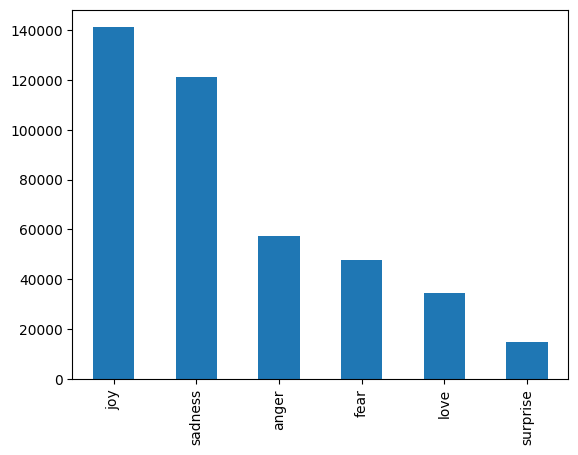

In [1]:
import torch
import torch.functional as F
import torch.nn as nn
import torch.optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader

import re
import numpy as np
import time
import pandas
import helpers.pickle_helpers as ph
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#Visualizing The Data

#Using PANDAS, importing the pickle data file
data = ph.load_from_pickle(directory = "data/merged_training.pkl") 
#plotting specific array from pickle file (pickle file has a collection of all the tensors saved in arrays)
data.emotions.value_counts().plot.bar()
#returns the first 10 rows of the dataframe, which is the tabular data storing the actual data
data.head(10)

#Preprocessing Data

#Tokenization: Before creating dictionaries, formatting
#Tokens: pretty much words, individual smaller units of the natural language data set
# retain only text that contain less that 70 tokens to avoid too much padding
# The data dictionary uses token_size array as a key, applies a function lambda(miscellanous fucntions with unlim parameters and 1 argument)
data["token_size"] = data["text"].apply(lambda x: len(x.split(' ')))
data = data.loc[data['token_size'] < 70].copy()

# Sampling: selecting specific subsets of datasets
#n=50000 --> the 50000th row of the dataset
data = data.sample(n=50000)

#Constructing Vocabulary and Index-Word Mapping
class ConstructVocab():
    #constructor, don't need seperate instance variable for python
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
    

    def create_index(self): #self parameter utilizes variables in the class, all of the instance variables
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(s.split(' '))
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0 (mapped to index 0)
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        #for machine to understand
        #enumerate: counting the iterations by assigning indexes to the words
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        #for humans to read after words are interpretetd by machine
        #from the sections in the word2idx items list (the possible responses)
        for word, index in self.word2idx.items():
            self.idx2word[index] = word  

#Forward Propogation
            
#Setting up the input data from the tensors imported and tokenized
#construct vocab and indexing
#changes the dataframe to lists to feed in as inout (2D lists)
inputs = ConstructVocab(data["text"].values.tolist())

# examples of what is in the vocab
inputs.vocab[0:10]

# vectorize to tensor
#converting the "text" row of data(dataFrame) to list of values
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')]  for es in data["text"].values.tolist()]
# examples of what is in the input tensors
input_tensor[0:2]

#Padding is usually used so that the shape or form of the data/tensor is in the same way. (convolutional layers)

#function rhat returns max value for all the tensors saved in length of input_tensor
def max_length(tensor):
    return max(len(t) for t in tensor)
# calculate the max_length of input tensor
max_length_inp = max_length(input_tensor)
print(max_length_inp)
#adding zeres to pad the data lengths
def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
    return padded

# inplace padding
input_tensor = [pad_sequences(x, max_length_inp) for x in input_tensor]
input_tensor[0:2]

#Binarization

### convert targets to one-hot encoding vectors(there is only one unique number in a whole row of '0's)
#used to locate which category the specific character is in. ex) if categorical # is 1, then index 1 should have the unique key
emotions = list(set(data.emotions.unique()))
num_emotions = len(emotions)
# binarizer
mlb = preprocessing.MultiLabelBinarizer() #transforms to binary seqeunce (categorical #s)
#intersection between column emotions and data in the dataFrame, and finds the emotions in the dataFrame that intersect with the predefined emotions (by matching categorical # indexes)
data_labels =  [set(emos) & set(emotions) for emos in data[['emotions']].values]
print(data_labels)

bin_emotions = mlb.fit_transform(data_labels) #identifies each item(of set arrays of emotions) using a binary matrix
target_tensor = np.array(bin_emotions.tolist()) # matrix of possible labels
target_tensor[0:2] 
data[0:2]

get_emotion = lambda t: np.argmax(t) #returns argmax of t, and argmax finds the index of the maximum value in an array
get_emotion(target_tensor[0])

emotion_dict = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}
emotion_dict[get_emotion(target_tensor[0])]

#Splitting Data

#Both types of data will be pre-processed
#input: user's text (predicted emotion) (predicted value)
#target: emotion (actual emotion) (true value)

#train: 80, test: 20 (train: training data, test: unseen data)
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
#this 20% for test, which is basically validation test data 

#50,50 out of the unseen data (50% for the training, 50% for the unseen data)
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5)
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test)

#Loading Data
TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 64
TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_inp_size = len(inputs.word2idx)
target_size = num_emotions

# convert the data to tensors and pass to the Dataloader 
# to create an batch iterator

class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        self.length = [ np.sum(1 - np.equal(x, 0)) for x in X]
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]
        return x, y, x_len
    
    def __len__(self):
        return len(self.data)
    
train_dataset = MyData(input_tensor_train, target_tensor_train)
val_dataset = MyData(input_tensor_val, target_tensor_val)
test_dataset = MyData(input_tensor_test, target_tensor_test)

train_dataset = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
val_dataset = DataLoader(val_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
test_dataset = DataLoader(test_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
print(train_dataset)


#Backward Propogation


In [4]:
import pickle
import pandas as pd

#data = pd.read_pickle("merged_training".pkl)
#print(data)

with open('merged_training.pkl', 'rb') as f:
    data = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'merged_training.pkl'

In [5]:
import pickle
import pandas as pd

data = pd.read_pickle("merged_training.pkl")
print(data)

with open('/Users/kylakim/Desktop/Thingiverse/Coding/CMU/data/serialized.pkl', 'rb') as f:
    data = pickle.load(f)

AttributeError: 'str' object has no attribute 'pkl'